# 1. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from rbergomi import RoughBergomi
import seaborn as sns
import numpy as np
import utils
from scipy import stats

sns.set_style("darkgrid")

In [3]:
# Set model parameters

params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "eta": 1.0,
    "H": 0.3,
    "rho": -0.7,
}

rbergomi = RoughBergomi(**params)

In [88]:
# generate paths
SEED = 1234
maturity = 1.0
n_disc = 300
tab_t = np.linspace(0.0, maturity, n_disc + 1)
dt = tab_t[1] - tab_t[0]
n_mc = 3 * 10**5
n_loop = 3

In [67]:
# paths = rbergomi.simulate(tab_t=tab_t, n_mc=n_mc, seed=SEED, conditioning=False)
# res = rbergomi.implied_vol(
#     T=maturity,
#     int_v_dt=paths["int_v_dt"],
#     int_sqrt_v_dw=paths["int_sqrt_v_dw"],
#     return_skew=True,
# )
# print(res)

In [68]:
# paths = rbergomi.simulate(tab_t=tab_t, n_mc=n_mc, seed=SEED, conditioning=True)
# res = rbergomi.implied_vol(
#     T=maturity,
#     int_v_dt=paths["int_v_dt"],
#     int_sqrt_v_dw=paths["int_sqrt_v_dw"],
#     conditioning=True,
#     return_skew=True,
# )
# print(res)

In [69]:
# rbergomi.atm_local_vol_skew(
#     v_t=paths["v"][-1, :],
#     int_v_dt=paths["int_v_dt"],
#     int_sqrt_v_dw=paths["int_sqrt_v_dw"],
# )

In [90]:
paths = rbergomi.simulate(
    tab_t=tab_t, n_mc=n_mc, n_loop=n_loop, seed=SEED, conditioning=True
)
w = paths["w"]
v = paths["v"]
paths = None

In [72]:
int_sqrt_v_dw_cumsum = np.cumsum(np.sqrt(v[:-1, :]) * np.diff(w, axis=0), axis=0)
int_v_dt_cumsum = np.cumsum(v[:-1, :] * dt, axis=0)
int_sqrt_v_dw_cumsum = np.insert(int_sqrt_v_dw_cumsum, 0, 0.0, axis=0)
int_v_dt_cumsum = np.insert(int_v_dt_cumsum, 0, 0.0, axis=0)
s_cumsum = rbergomi.s0 * np.exp(int_sqrt_v_dw_cumsum - 0.5 * int_v_dt_cumsum)

In [77]:
n_split = n_disc // 50

int_sqrt_v_dw_split = np.array(
    [t[-1] for t in np.split(int_sqrt_v_dw_cumsum[1:], n_split, axis=0)]
)
int_v_dt_split = np.array(
    [t[-1] for t in np.split(int_v_dt_cumsum[1:], n_split, axis=0)]
)
v_split = np.array([t[-1] for t in np.split(v[1:, :], n_split, axis=0)])
tab_t_split = np.array([t[-1] for t in np.split(tab_t[1:], n_split)])

print(f"split in {n_split} parts, each with {n_disc // n_split} time steps")

split in 6 parts, each with 50 time steps


In [78]:
v_split.shape

(6, 300000)

In [79]:
atm_implied_vol = np.zeros(n_split)
atm_implied_vol_skew = np.zeros(n_split)
atm_local_vol_skew = np.zeros(n_split)

for i in range(n_split):
    atm_implied_vol[i], atm_implied_vol_skew[i] = rbergomi.implied_vol(
        T=tab_t_split[i],
        int_v_dt=int_v_dt_split[i, :],
        int_sqrt_v_dw=int_sqrt_v_dw_split[i, :],
        conditioning=True,
        return_skew=True,
    )
    atm_local_vol_skew[i] = rbergomi.atm_local_vol_skew(
        v_t=v_split[i, :],
        int_v_dt=int_v_dt_split[i, :],
        int_sqrt_v_dw=int_sqrt_v_dw_split[i, :],
    )

/var/folders/cx/lqg_nbts2gd5hgdpftngz4z80000gn/T/ipykernel_96559/1485233578.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  atm_implied_vol[i], atm_implied_vol_skew[i] = rbergomi.implied_vol(


In [80]:
print(1.0 / (rbergomi.H + 1.5))
print(atm_implied_vol_skew / atm_local_vol_skew)

0.5555555555555556
[0.53799861 0.53864651 0.54154585 0.55355296 0.55889716 0.56175291]


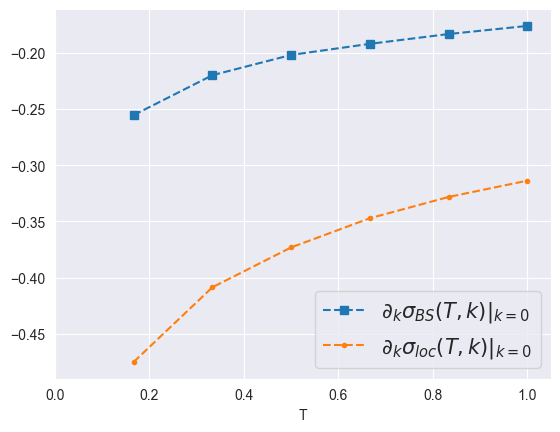

In [83]:
plt.close()
fig, ax = plt.subplots()
ax.plot(
    tab_t_split,
    atm_implied_vol_skew,
    "--s",
    label="$\\partial_k \\sigma_{BS}(T,k)|_{k=0}$",
)
ax.plot(
    tab_t_split,
    atm_local_vol_skew,
    "--.",
    label="$\\partial_k \\sigma_{loc}(T,k)|_{k=0}$",
)
ax.set_xlabel("T")
ax.set_xlim(0.0, tab_t_split[-1] * 1.05)
# plt.title(
#     f"$\\xi_0={round(xi0, 3)}$, $\\eta={eta}$, $H={H}$, $\\rho={rho}$, $\\theta={theta}$, $n={n}$, $M={M:.1e}$",
#     size=12,
# )
ax.legend(fontsize=15)
plt.show()

In [85]:
label = "$\\frac{\\partial_x \\sigma_{BS}(T,x)|_{x=0}}{\\partial_x \\sigma_{loc}(T,x)|_{x=0}}$"

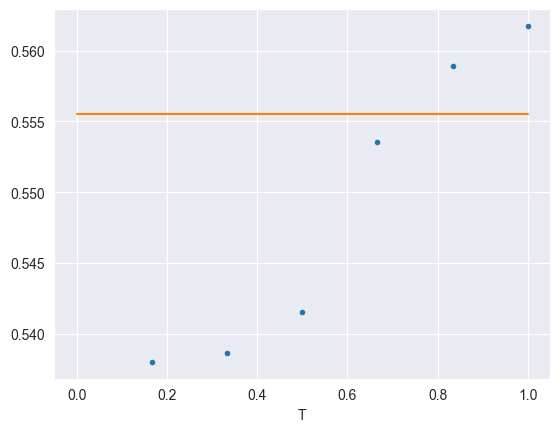

In [87]:
plt.close()
fig, ax = plt.subplots()
plt.plot(tab_t_split, atm_implied_vol_skew / atm_local_vol_skew, ".", label=label)
plt.plot(
    tab_t,
    1.0 / (rbergomi.H + 1.5) * np.ones_like(tab_t),
    "-",
    label="$\\frac{1}{H+\\frac{3}{2}}$",
)
ax.set_xlabel("T")
plt.show()

In [ ]:
# Simulate cases: H=0.1, 0.3, 0.5